In [1]:
import numpy as np
import torch as ch
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from robustness import datasets
from robustness.model_utils import make_and_restore_model
from robustness.tools.vis_tools import show_image_column, show_image_row
from robustness.tools.label_maps import CLASS_DICT
from pathlib import Path
from torchvision import transforms
from utils import RGBAToRGB, ModelDataset, details_df
from colorsys import hsv_to_rgb, rgb_to_hsv
from make_predictions import make_predictions
from tqdm import tqdm
import os
from objectnet_utils import OBJN_TO_IN_MAP

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
perclass_acc_df = pd.read_csv('per_class_color_good.csv')
res_file = 'whole_eval_good.csv'

In [3]:
class Flatten():
    def __call__(self, im, target=None):
        if type(im) == tuple:
            im = im[0]
        return im

class UnFlatten():
    def __call__(self, im, target=None):
        return (im, target)

In [50]:
IN_TO_OBJN_MAP = {str(v): k for k, v in OBJN_TO_IN_MAP.items()}

## Try all dataset

In [4]:
if not os.path.exists(res_file):

    DS_PATH = '/scratch/datasets/sandbox/v0'
    ds_path = Path(DS_PATH)
    root_df = details_df(ds_path)

    ds = datasets.ImageNet((ds_path, root_df))

    m, _ = make_and_restore_model(arch='resnet50', 
                                              dataset=datasets.ImageNet('/scratch/engstrom_scratch/imagenet'),
                                              pytorch_pretrained=True)
    m.eval()
    m = ch.nn.DataParallel(m.cuda())

    ds.custom_class = ModelDataset
    ds.custom_class_args = {
        #'subset': args.num_examples,
        'model_filter': ch.load('good_models.pt')
    }


    ds.transform_test = transforms.Compose([
                #RGBAToRGB(hsv_to_rgb(1, 1, 1)),
                #transforms.CenterCrop(224),
                Flatten(),
                transforms.ToTensor()
            ])
    _, loader = ds.make_loaders(workers=10, 
                                        batch_size=200, 
                                        only_val=True)

    class_specific_transforms = {}
    class_specific_transforms_info = {}

    for i in range(len(perclass_acc_df)):
        d = perclass_acc_df.iloc[i]
        res = [d[k] for k in ['labs',  'hue', 'saturation', 'value']]
        labs, h, s, v = res
        class_specific_transforms[str(labs)] = transforms.Compose([
                                                    transforms.ToPILImage(),
                                                    UnFlatten(),
                                                    RGBAToRGB(hsv_to_rgb(h, s, v)),
                                                    transforms.CenterCrop(224),
                                                    transforms.ToTensor()
                                                ])
        class_specific_transforms_info[str(labs)] = (h, s, v)

    mode = 'restrict'

    in_classes = [] 
    for v in OBJN_TO_IN_MAP.values():
        in_classes.extend(v)
    in_classes = list(set(in_classes))

    res_dfs = []
    with ch.no_grad():
        for jj, (ims, labs, uids) in tqdm(enumerate(loader), total=len(loader)):
            labs = [OBJN_TO_IN_MAP[int(l)] for l in labs.cpu()]
            info = [class_specific_transforms_info[str(l)] for l in labs]

            ims = ch.stack([class_specific_transforms[str(l)](im)
                          for im, l in zip(ims, labs) 
                          if str(l) in class_specific_transforms])
            ims = ims[:,:3,...].cuda() # RGBA -> RGB
            op = m(ims)[0]
            if mode != 'restrict':
                preds = ch.argmax(op, dim=1).cpu()
            else:
                op = op[:, in_classes]
                preds = ch.argmax(op, dim=1).cpu()
                preds = ch.tensor([in_classes[int(p)] for p in preds])
            res_dfs.append(pd.DataFrame({'uids': uids,
                                    'preds': preds.cpu().numpy(),
                                    'labs': labs,
                                    'info': info}))
            #if jj == 5: break
    res_dfs = pd.concat(res_dfs)
    res_dfs['sameclass'] = res_dfs.apply(lambda r: r['preds'] in r['labs'], axis=1)
    print(np.mean(res_dfs['sameclass']))
    res_dfs.to_csv(res_file)
    
else:
    res_dfs = pd.read_csv(res_file)

==> Preparing dataset imagenet..


100%|██████████| 3352/3352 [51:36<00:00,  1.08it/s]


0.4894331742243437


In [5]:
res_dfs

,uids,preds,labs,info,sameclass
0,d1716739-0e75-4a44-b6c6-b16d60a318bb,772,[846],"(0.0, 0.0, 0.30000000000000004)",False
1,45426a37-bf93-4f0e-808f-bfe856769012,902,[679],"(0.0, 0.0, 1.0)",False
2,66fd9c1f-7053-46c2-8b3c-b26b9d675635,677,[837],"(0.0, 0.0, 1.0)",False
3,5e2900fc-e33f-4ea7-bb6e-b2a05a69b140,813,[499],"(0.5, 0.1, 0.7000000000000001)",False
4,7527c2e4-ec75-407b-9a7b-3f7a8ddb1d57,559,[578],"(0.4, 0.4, 0.6000000000000001)",False
...,...,...,...,...,...
195,cc313093-2cad-4d92-a376-355d4bb2d989,769,[587],"(0.0, 0.0, 0.9)",False
196,4d202ab1-e05c-468e-b85e-c970655d07eb,778,[909],"(0.0, 0.0, 1.0)",False
197,744de671-455a-491b-8e4b-736d29e56483,749,[841],"(0.1, 0.2, 1.0)",False
198,07ce2b81-4d4f-4896-ac5b-1d2f8758f3f8,419,[419],"(0.6000000000000001, 0.2, 1.0)",True


In [8]:
res_dfs['labs'] = [str(l) for l in res_dfs['labs']]

In [15]:
img_to_uuid = np.load('image_id_to_uuid.npy', allow_pickle=True).item()

## Model count

In [16]:
res_dfs['uuids'] = [img_to_uuid[u] for u in res_dfs['uids']]

In [20]:
res_dfs

,uids,preds,labs,info,sameclass,uuids
0,d1716739-0e75-4a44-b6c6-b16d60a318bb,772,[846],"(0.0, 0.0, 0.30000000000000004)",False,7be9e6cbf6e04365a028217a4874730e
1,45426a37-bf93-4f0e-808f-bfe856769012,902,[679],"(0.0, 0.0, 1.0)",False,ef10ae8876b94850ba75c2af834a8893
2,66fd9c1f-7053-46c2-8b3c-b26b9d675635,677,[837],"(0.0, 0.0, 1.0)",False,3f0b70dcf48347adb60945fff3072984
3,5e2900fc-e33f-4ea7-bb6e-b2a05a69b140,813,[499],"(0.5, 0.1, 0.7000000000000001)",False,8b3a394b1e6741e187e15b8dc5075b54
4,7527c2e4-ec75-407b-9a7b-3f7a8ddb1d57,559,[578],"(0.4, 0.4, 0.6000000000000001)",False,b76fb474aabf46859d07ee851b1753ce
...,...,...,...,...,...,...
195,cc313093-2cad-4d92-a376-355d4bb2d989,769,[587],"(0.0, 0.0, 0.9)",False,499f9f5c37cc4ed587367ae1d176e992
196,4d202ab1-e05c-468e-b85e-c970655d07eb,778,[909],"(0.0, 0.0, 1.0)",False,ad73e31b3f4543de9a6f42d9ff3e3f1c
197,744de671-455a-491b-8e4b-736d29e56483,749,[841],"(0.1, 0.2, 1.0)",False,a09592f04ebb495c9641ea1e7630b1de
198,07ce2b81-4d4f-4896-ac5b-1d2f8758f3f8,419,[419],"(0.6000000000000001, 0.2, 1.0)",True,4ea9ba2813f24416ad164b4fd3300dc6


In [23]:
model_df = res_dfs.groupby(['labs']).agg(num=('uuids', lambda x: x.nunique())).reset_index()

In [24]:
model_df

,labs,num
0,"[409, 530]",19
1,[412],73
2,[414],38
3,"[418, 749, 563]",47
4,[419],1
...,...,...
93,[950],18
94,[951],12
95,[954],45
96,[968],1


## Per-class

In [9]:
perclass_acc_df = res_dfs.groupby(['labs', 'preds', 'info']).agg(num=('uids', 'count')).reset_index()
perclass_acc_df['labs_int'] = perclass_acc_df.labs.apply(lambda x: [int(xx) for xx in x[1:-1].split(',')])
perclass_acc_df['sameclass'] = perclass_acc_df.apply(lambda r: r['preds'] in r['labs_int'], axis=1)

In [10]:
perclass_acc_df = perclass_acc_df.groupby(['info'] + ['sameclass', 'labs']).agg({'num': 'sum'}).reset_index()
perclass_acc_df = perclass_acc_df.pivot_table(index=['info'] + ['labs'], 
                                              columns='sameclass', values='num',
                                              fill_value=0).reset_index()
perclass_acc_df['acc'] = perclass_acc_df[True] / (perclass_acc_df[True] + perclass_acc_df[False])
perclass_acc_df['count'] = (perclass_acc_df[True] + perclass_acc_df[False])
perclass_acc_df

sameclass,info,labs,False,True,acc,count
0,"(0.0, 0.0, 0.0)",[455],1770,0,0.000000,1770
1,"(0.0, 0.0, 0.0)","[457, 906]",4996,4,0.000800,5000
2,"(0.0, 0.0, 0.0)",[588],3479,1851,0.347280,5330
3,"(0.0, 0.0, 0.0)",[619],1926,1614,0.455932,3540
4,"(0.0, 0.0, 0.0)",[923],5188,2,0.000385,5190
...,...,...,...,...,...,...
93,"(0.8, 0.7000000000000001, 0.8)",[673],3132,2788,0.470946,5920
94,"(0.8, 1.0, 1.0)","[409, 530]",5050,2640,0.343303,7690
95,"(0.9, 0.2, 0.9)",[721],3907,1303,0.250096,5210
96,"(0.9, 0.30000000000000004, 0.9)",[543],549,9461,0.945155,10010


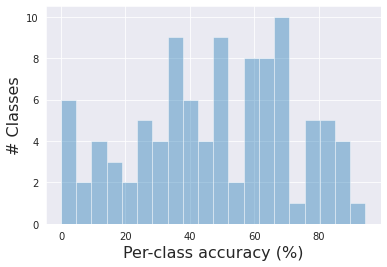

In [11]:
sns.distplot(100 * perclass_acc_df['acc'], kde=False, bins=20)
plt.xlabel('Per-class accuracy (%)', fontsize=16)
plt.ylabel('# Classes', fontsize=16)
plt.show()

## Find good classes

In [29]:
label_to_model_count = {k: v for k, v in zip(model_df['labs'], model_df['num'])}

In [30]:
perclass_acc_df['model_count'] = perclass_acc_df.apply(lambda r: label_to_model_count[r['labs']], axis=1)

In [61]:
label_t, acc_t = 10, 30
good_df = perclass_acc_df[np.logical_and(perclass_acc_df['model_count'] > label_t,
                               100 * perclass_acc_df['acc'] > acc_t)]

In [62]:
good_df

sameclass,info,labs,False,True,acc,count,model_count
6,"(0.0, 0.0, 0.30000000000000004)",[846],4214,1946,0.315909,6160,24
9,"(0.0, 0.0, 0.6000000000000001)",[898],2224,4176,0.652500,6400,24
10,"(0.0, 0.0, 0.7000000000000001)",[626],4658,2812,0.376439,7470,44
11,"(0.0, 0.0, 0.9)","[423, 559, 765]",881,4169,0.825545,5050,208
15,"(0.0, 0.0, 1.0)",[740],2742,5528,0.668440,8270,12
16,"(0.0, 0.0, 1.0)",[837],2549,4851,0.655541,7400,23
19,"(0.0, 0.1, 1.0)",[610],4337,2173,0.333794,6510,34
20,"(0.0, 0.2, 0.7000000000000001)",[504],3179,1671,0.344536,4850,133
21,"(0.0, 0.4, 1.0)","[560, 518]",3793,2287,0.376151,6080,174
22,"(0.0, 0.5, 0.2)",[508],4406,3144,0.416424,7550,63


In [63]:
np.save(f'./good_classes/{label_t}_{acc_t}.npy', 
        [IN_TO_OBJN_MAP[l] for l in good_df['labs']])

In [64]:
len(good_df)

35